# EV Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar

import os
from glob import glob

In [2]:
%matplotlib notebook
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

## Import jsons

In [3]:
def convert_to_datetime(timestamp_as_str):
    """Convert a timestring as str to pandas timestring dtype

    Args:
        timestamp_as_str: Timestamp in string format

    Returns:
        A readable timestamp for pandas
    """
    date, time, time_ns = timestamp_as_str.split('_')
    return pd.to_datetime(date + ' ' + time + '.' + time_ns)


def import_trasient_from_file(url_of_folder):
    """Get jsons from a folder and put them into a DataFrame

    Args:
        url_of_folder: The url where we can find all jsons

    Returns:
        A DataFrame with all transients and all
        relevant information
    """
    append_data = []

    # find out how many files in the folder
    list = os.listdir(url_of_folder)
    number_files = len(list)
    bar = progressbar.ProgressBar()
    with progressbar.ProgressBar(max_value=number_files) as bar:
        for i, file_name in enumerate(glob(url_of_folder + '*.json')):
            data = pd.read_json(file_name)
            append_data.append(data)
            bar.update(i)
        all_data = pd.concat(append_data, axis=1).transpose()
    only_trasients = all_data[all_data["transient_flag"] == "true"] \
        .reset_index() \
        .drop(['index', 'transient_flag'], 1)
    # convert object types to float, timestamp, int
    only_trasients['begin_timestamp_string'] = \
        only_trasients['begin_timestamp_string'].apply(convert_to_datetime)

    numric_colums = ['begin_index',
                     'begin_timestamp_float',
                     'phase_num',
                     'transient_rise_gradient']
    only_trasients[numric_colums] = only_trasients[numric_colums] \
        .apply(pd.to_numeric)
    return only_trasients

In [4]:
%time data = import_trasient_from_file("jsons/")

100% (1370 of 1370) |#####################| Elapsed Time: 0:00:16 Time: 0:00:16


CPU times: user 14.9 s, sys: 3.02 s, total: 17.9 s
Wall time: 18.4 s


## Explore the data

This chapter should give a overview of the used dataset. Therefore step one is to study the header of the dataset. Here the column *'begin_timestamp_float'* can be used as a index, make our're events easier to find and to compare with other data sources. 

In [5]:
length = len(data)
print("Number of data points: {}".format(length))
data.head(1)

Number of data points: 1882


,begin_index,begin_timestamp_float,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient
0,701,1.491027e+09,2017-01-04 08:01:41.529732,"[7.9862e-06, 0.0259479208, -0.0389019368, 7.97...",2,"[0.6561279297, 0.7019042969, 0.7629394531, 0.7...","[289.647277832, 289.6991882324, 289.8029785156...","[26.198, 4.360, 2.076]","[754, 884, 1015]",245806.997513


In [6]:
transient_overview = pd.read_csv('transientlist.csv', sep=',', header=None)
transient_overview[0] = transient_overview[0].apply(convert_to_datetime)
len(transient_overview)

# output: 1370

1370

In [7]:
transient_overview.sort_values(0).head(1)

,0,1,2,3
733,2017-01-04 08:01:41.528330,7681,[2],26.198


In [8]:
data.sort_values('begin_timestamp_string').head(1)

,begin_index,begin_timestamp_float,begin_timestamp_string,filtered_signal,phase_num,raw_signal_current,raw_signal_voltage,three_first_peaks,three_first_peaks_index,transient_rise_gradient
0,701,1.491027e+09,2017-01-04 08:01:41.529732,"[7.9862e-06, 0.0259479208, -0.0389019368, 7.97...",2,"[0.6561279297, 0.7019042969, 0.7629394531, 0.7...","[289.647277832, 289.6991882324, 289.8029785156...","[26.198, 4.360, 2.076]","[754, 884, 1015]",245806.997513


## Preprossing Data

The next step is to Preprocessing the Data. In this present Case it's possible that the transient detect only on one phase, two phases or all phases. Therefore it's important to ascertain how often one of the three events is detecteted. Then we can create seperate Dataframe for this three events.

In [69]:
%%time
from collections import Counter
#documentation : https://docs.python.org/2/library/collections.html

# put all timestamps to a list
# and create a dict with Counter() to get a timestamp as key and a value how often we can find this timestamp
timestamps = data['begin_timestamp_float'].tolist()
counter_timestamps = Counter()
for timestamp in timestamps:
    counter_timestamps[timestamp] += 1

# create a series from the counter object, that we can handle better the information
counter_timestamps_series = pd.Series(counter_timestamps)
data_point_num = len(counter_timestamps_series)
data_points_per_phase = counter_timestamps_series.value_counts()

# print all the result
print("All events: {}".format(data_point_num))
print("Events with one phase: {}".format(data_points_per_phase[1]))
print("Events with two phases: {}".format(data_points_per_phase[2]))
print("Events with three phases: {}".format(data_points_per_phase[3]))

All events: 1568
Events with one phase: 1305
Events with two phases: 212
Events with three phases: 51
CPU times: user 3.99 ms, sys: 547 µs, total: 4.54 ms
Wall time: 4.14 ms


In [129]:
from collections import Counter
#documentation : https://docs.python.org/2/library/collections.html

def seperate_transients(input_df):
    
    # put all timestamps to a list
    # and create a dict with Counter() to get a timestamp as key and a value how often we can find this timestamp
    timestamps = data['begin_timestamp_float'].tolist()
    # create a counter object
    counter_timestamps = Counter()
    # count how often one Timestamp is in the list
    for timestamp in timestamps:
        counter_timestamps[timestamp] += 1
 
    # create a series from the counter object, that we can handle better the information    
    counter_timestamps_series = pd.Series(counter_timestamps)
    
    input_df_time_index = input_df.set_index('begin_timestamp_float')
    # create three new df
    # take the header from the input data
    header = raw_data.dtypes.index
    
    one_phase_df = pd.DataFrame(columns=header)
    two_phase_df = pd.DataFrame(columns=header)
    three_phase_df = pd.DataFrame(columns=header)
    
    for index, row in input_df_time_index.iterrows():
        num_phase = counter_timestamps_series[index]
        # Events with one phase
        if(num_phase == 1):
            one_phase_df = one_phase_df.append(row)
        # Events with two phases
        elif(num_phase == 2):
            two_phase_df = two_phase_df.append(row)
        # Events with three phases
        elif(num_phase == 3):
            three_phase_df = three_phase_df.append(row)
            
    # take the dtypes from the input header
    dtypes = dict(raw_data.dtypes)
    one_phase_df = one_phase_df.astype(dtype=dtypes)
    two_phase_df = two_phase_df.astype(dtype=dtypes)
    three_phase_df = three_phase_df.astype(dtype=dtypes)
    return [one_phase_df, two_phase_df, three_phase_df]

In [134]:
%time transients_1_phase, transients_2_phase, transients_3_phase = seperate_transients(data)

CPU times: user 6.81 s, sys: 11 ms, total: 6.82 s
Wall time: 6.81 s


### Create Feature Dataframe from exist features

The Problem with time series is, that they are high dimensional. Therefore it's important to extract features from this time series to reduce the dimensions of the data. So the next step is to preprocessing our data, that we can extract features from this Dataframe. We will create a Dataframe for the current/voltage signals.

In [48]:
def create_feature_dataframe(input_data):
    # preprocessing input data
    # drop all unnecessary columns
    input_data = input_data.drop(['begin_index','begin_timestamp_string',
                                  'filtered_signal','raw_signal_current',
                                  'raw_signal_voltage'], 1)
    # seperate peaks
    input_data[['peak_1','peak_2','peak_3']] = input_data['three_first_peaks'].apply(pd.Series)
    # seperate peak index
    input_data[['p_index_1','p_index_2','p_index_3']] = input_data['three_first_peaks_index'].apply(pd.Series)
    
    # cleanup dataframe
    input_data = input_data.drop(['three_first_peaks','three_first_peaks_index'], 1)
    # new_index
    input_data = input_data.set_index(input_data['begin_timestamp_float'])
    
    # create empty dataframe
    # unique()
    unique_timestamps = input_data['begin_timestamp_float'].unique()
    index = unique_timestamps
    columns = ['phase_1_peak_1','phase_1_peak_2','phase_1_peak_3',
               'phase_2_peak_1','phase_2_peak_2','phase_2_peak_3',
               'phase_3_peak_1','phase_3_peak_2','phase_3_peak_3']
    feature_df = pd.DataFrame(np.nan, index=index, columns=columns)
    
    # insert first 
    for index, row in input_data.iterrows():
        phase_num = row['phase_num']
        if(phase_num == 1):
            feature_df.set_value(
                index,
                ['phase_1_peak_1','phase_1_peak_2','phase_1_peak_3'],
                [row['peak_1'],row['peak_2'],row['peak_3']]
                )            
        # Case 2: Phase 2
        elif(phase_num == 2):
            feature_df.set_value(
                index,
                ['phase_2_peak_1','phase_2_peak_2','phase_2_peak_3'],
                [row['peak_1'],row['peak_2'],row['peak_3']]
                )
        # Case 3: Phase 3
        elif(phase_num == 3):
            feature_df.set_value(
                index,
                ['phase_3_peak_1','phase_3_peak_2','phase_3_peak_3'],
                [row['peak_1'],row['peak_2'],row['peak_3']]
                )
        # Case 4: All undefine Cases
        else:
            print('Error')
    #print(input_data['transient_rise_gradient'])
    #feature_df['transient_rise_gradient'] = input_data['transient_rise_gradient']
    
    return(feature_df)

In [49]:
%time feature_df = create_feature_dataframe(data)

CPU times: user 2.22 s, sys: 7.59 ms, total: 2.23 s
Wall time: 2.23 s


# Spielen

In [177]:
Z = linkage(feature_df, 'ward')

In [178]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(feature_df))
c

0.68034015253242963

In [183]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

<IPython.core.display.Javascript object>


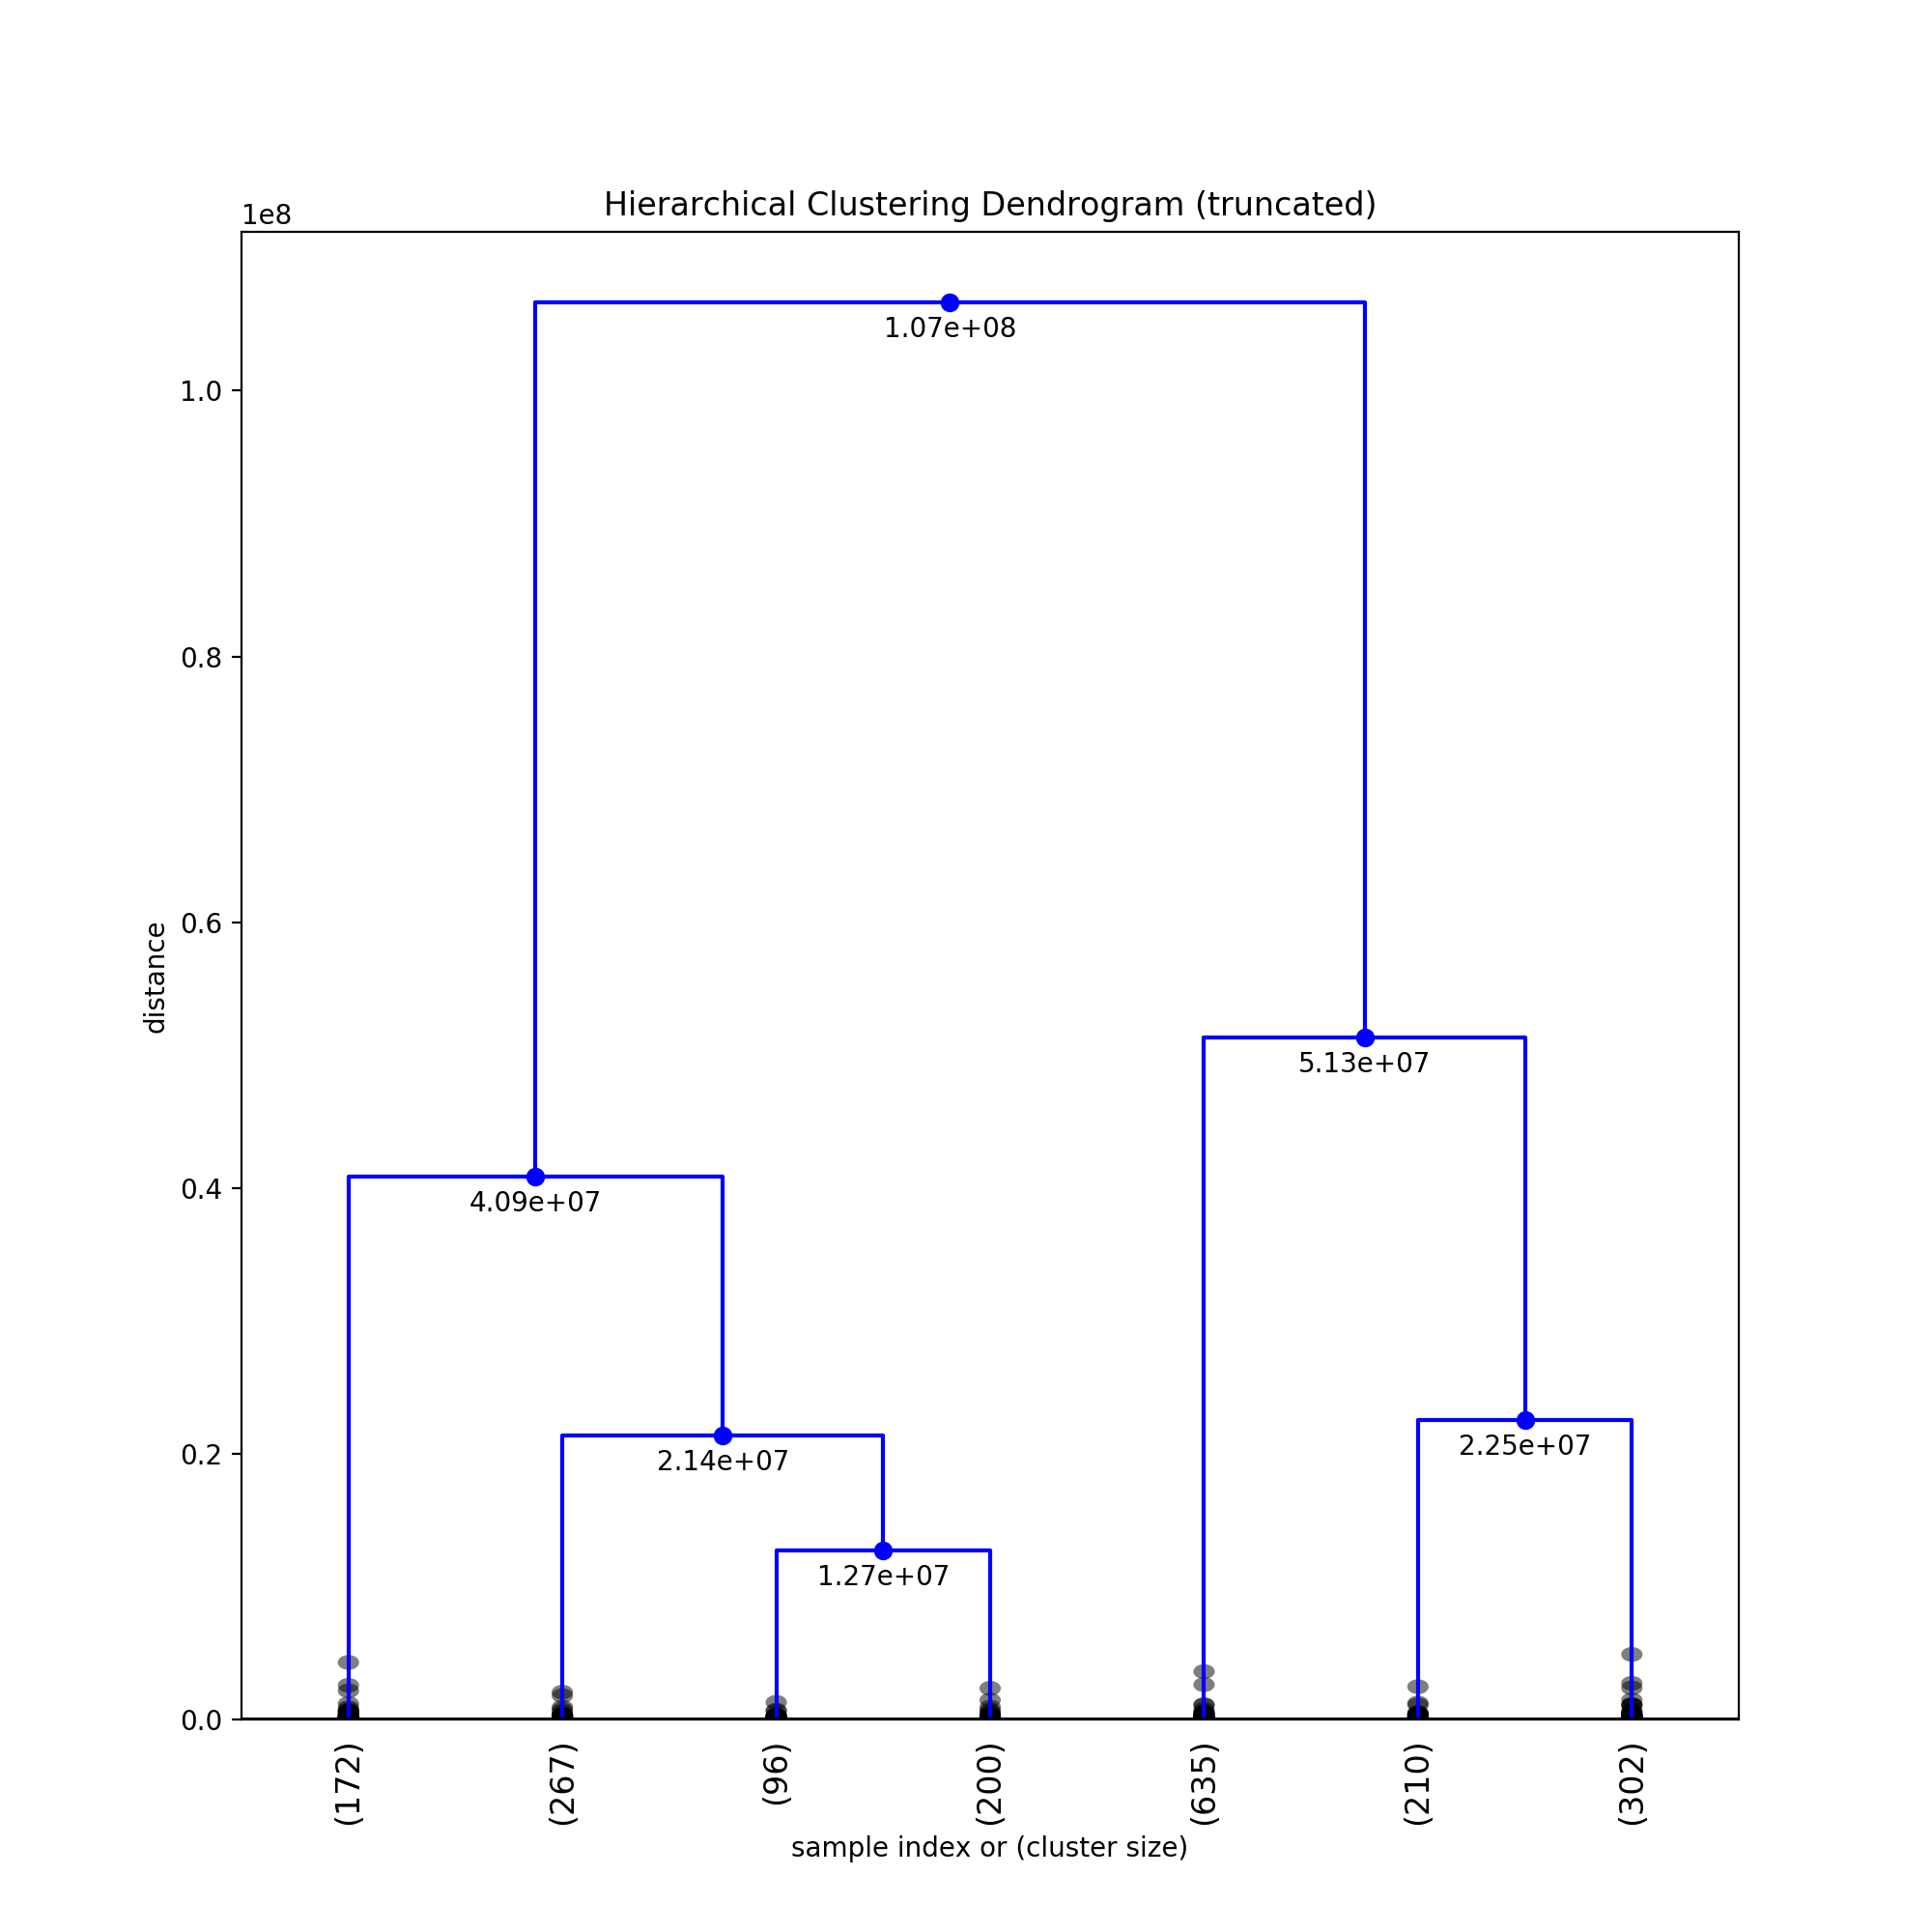

In [191]:
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=7,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

In [8]:
# create trasient data frame
raw_signal_current = data["raw_signal_current"]
raw_signal_voltage = data["raw_signal_voltage"]

# create dataframes
# on row contains on time series
# column is time or dimension
df_raw_signal_current = pd.DataFrame([x for x in raw_signal_current])
df_raw_signal_voltage = pd.DataFrame([x for x in raw_signal_voltage])

In [9]:
df_raw_signal_current.head(1)

,0,1,2,3,4,5,6,7,8,9,...,10016,10017,10018,10019,10020,10021,10022,10023,10024,10025
0,0.656128,0.701904,0.762939,0.701904,0.686646,0.762939,0.732422,0.686646,0.717163,0.686646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_raw_signal_voltage.head(1)

,0,1,2,3,4,5,6,7,8,9,...,10016,10017,10018,10019,10020,10021,10022,10023,10024,10025
0,289.647278,289.699188,289.802979,289.828949,289.932739,290.04953,290.10144,290.270111,290.373932,290.490723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clustering

### Extract Features Voltage (mit tsfresh)

Quelle Bild:
https://tsfresh.readthedocs.io/en/latest/_images/feature_extraction_process_20160815_mc_1.png

In [11]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import FeatureExtractionSettings

extraction_settings = FeatureExtractionSettings()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

# transpose since tsfresh reads times series data column-wise, not row-wise
df_raw_signal_voltage_t = df_raw_signal_voltage.copy().transpose()
df_raw_signal_voltage_t_cut = df_raw_signal_voltage_t[:100]

print(df_raw_signal_voltage_t_cut.shape)
len(df_raw_signal_voltage_t_cut.columns)

In [18]:
# rearrange voltage column-wise, not row-wise

master_df = pd.DataFrame(df_raw_signal_voltage_t_cut[0])
master_df['id'] = 0

bar = progressbar.ProgressBar()

with progressbar.ProgressBar(max_value=len(df_raw_signal_voltage_t_cut.columns)) as bar:
    for i in range(1,500): #len(df_raw_signal_voltage_t.columns)
        signal_df = pd.DataFrame(df_raw_signal_voltage_t_cut[i])
        signal_df['id'] = i
        master_df = pd.DataFrame(np.vstack([master_df, signal_df]))
        bar.update(i)

100% (1882 of 1882) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


In [19]:
master_df.shape

(50000, 2)

In [20]:
new_master_df = master_df.dropna(how='any')
new_master_df.shape

(50000, 2)

In [21]:
%time X = extract_features(new_master_df, column_id=1, feature_extraction_settings=extraction_settings)

Feature Extraction: 100%|██████████| 500/500 [00:28<00:00, 17.29it/s]

CPU times: user 973 ms, sys: 186 ms, total: 1.16 s
Wall time: 29.1 s
